In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.cross_validation import cross_val_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
%matplotlib inline

In [2]:
data = pd.read_csv('data/comments.csv.gz')

In [3]:
data.shape

(180687, 6)

In [4]:
data.is_gum.value_counts()

1.0    90633
0.0    90054
Name: is_gum, dtype: int64

In [5]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,360037882,"[id352784000|Алексей], 2:1",0.0,18,1,2
1,360037882,НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ...,0.0,18,35,2
2,360037882,"[id34736142|Андрей], не имеет значение где ЮР,...",0.0,10,0,2


### Length of comments (symbols)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180687 entries, 0 to 180686
Data columns (total 6 columns):
from_id    180687 non-null int64
text       180687 non-null object
is_gum     180687 non-null float64
hour       180687 non-null int64
likes      180687 non-null int64
sex        180687 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 8.3+ MB


In [7]:
lenghts_symb = np.array([len(m) for m in data.text.values])

In [8]:
lenghts_symb.mean(), np.median(lenghts_symb)

(77.064913358459663, 47.0)

In [9]:
min(lenghts_symb), max(lenghts_symb)

(1, 9947)

In [10]:
sum(lenghts_symb)

13924628

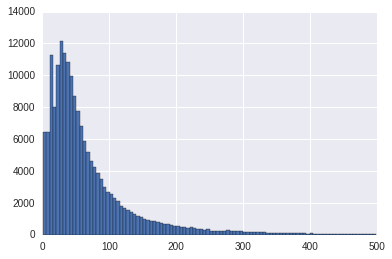

In [11]:
plt.hist(lenghts_symb[lenghts_symb < 500], bins=100);

In [12]:
print('{:.2f}% of comments are shorter than {} symbols'
      .format(lenghts_symb[lenghts_symb < 500].shape[0] / lenghts_symb.shape[0] * 100, 500))

99.04% of comments are shorter than 500 symbols


In [13]:
print('{:.2f}% of comments are longer than {} symbols'
      .format(lenghts_symb[lenghts_symb > 20].shape[0] / lenghts_symb.shape[0] * 100, 15))

82.19% of comments are longer than 15 symbols


### Length of comments (words)

In [14]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [15]:
lenghts_word.mean(), np.median(lenghts_word)

(11.438432205969439, 7.0)

In [16]:
min(lenghts_word), max(lenghts_word)

(1, 1612)

In [17]:
sum(lenghts_word)

2066776

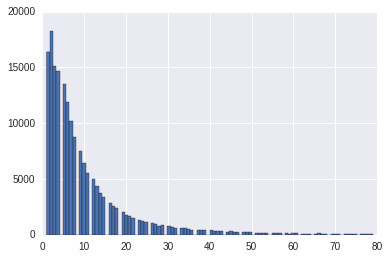

In [18]:
plt.hist(lenghts_word[lenghts_word < 80], bins=100);

In [19]:
print('{:.2f}% of comments are shorter than {} words'
      .format(lenghts_word[lenghts_word < 80].shape[0] / lenghts_word.shape[0] * 100, 80))

99.04% of comments are shorter than 80 words


In [20]:
print('{:.2f}% of comments are longer than {} words'
      .format(lenghts_word[lenghts_word > 3].shape[0] / lenghts_word.shape[0] * 100, 3))

72.44% of comments are longer than 3 words


### Links

In [21]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 

In [22]:
links[:5]

['[id99906417|Илья], http://prostitutki-voronezha.info/',
 'Вот, как раз на эту тему http://s02.yapfiles.ru/files/531066/SHkala_masshtabov_Vselennoy_v.2.swf Про масштабы вселенной, админы проигнорили мой пост, видимо про котят интереснее.....',
 'Она каким то образом пишет в вк? Значит у нее есть доступ к 2gis.ru',
 'http://www.zakonrf.info/koap/20.1/',
 'http://m.youtube.com/#/watch?feature=youtu.be&v=yfDOcUSLZ6o&desktop_uri=%2Fwatch%3Fv%3DyfDOcUSLZ6o%26feature%3Dyoutu.be\nДоставило, особенно комментарии. Спасители наши']

In [23]:
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.57% of comments contain links


## Baseline model

In [28]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(data.text.values)
y = data.is_gum.values

In [137]:
lr = lm.LogisticRegression()

In [138]:
np.random.seed(0)

### CV result

In [37]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.52080136820649048, 0.012812570384976506)

### Overfitted result

In [38]:
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [139]:
lr.fit(is_man, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
lr.coef_.argmax()

1096

In [41]:
vectorizer.get_feature_names()[1096]

'yulya'

## Preprocessing

### Dropping short and long

In [24]:
comments = data[(lenghts_word < 80) & (lenghts_word > 3)]

In [25]:
comments.shape

(129171, 6)

### Dropping with spam

In [26]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True for c in comments.text.values] 

In [27]:
comments = comments[without_link]

In [28]:
comments.shape

(128510, 6)

In [29]:
comments_lenghts = np.array([len(m) for m in comments.text.values])

In [30]:
comments_lenghts.argsort()[:10]

array([11301, 62379, 11311, 83904,  9999, 12971, 79765, 68894, 12527, 12526])

In [49]:
comments.text.values[11311]

'👍 👍 👍 👍'

In [31]:
comments.is_gum.value_counts()

0.0    64970
1.0    63540
Name: is_gum, dtype: int64

In [51]:
comments.text.values[102:104]

array([ '[id168803274|Артём], воооот) а у меня батя дальнобойщик. Я не понаслышке знаю что такое груженый тягач) в общем, мы друг друга поняли!)',
       '[id13014907|Сергей], когда воздух уходит из системы- машина растормаживается, т.е. все колёса блокируются. Тормоза на новых тягачах не отказывают. Это вам не КрАЗ'], dtype=object)

In [52]:
[t.split() for t in comments.text.values[102:104]]

[['[id168803274|Артём],',
  'воооот)',
  'а',
  'у',
  'меня',
  'батя',
  'дальнобойщик.',
  'Я',
  'не',
  'понаслышке',
  'знаю',
  'что',
  'такое',
  'груженый',
  'тягач)',
  'в',
  'общем,',
  'мы',
  'друг',
  'друга',
  'поняли!)'],
 ['[id13014907|Сергей],',
  'когда',
  'воздух',
  'уходит',
  'из',
  'системы-',
  'машина',
  'растормаживается,',
  'т.е.',
  'все',
  'колёса',
  'блокируются.',
  'Тормоза',
  'на',
  'новых',
  'тягачах',
  'не',
  'отказывают.',
  'Это',
  'вам',
  'не',
  'КрАЗ']]

In [53]:
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(comments.text.values)
y = comments.is_gum.values

In [91]:
lr = lm.LogisticRegression()

In [55]:
np.random.seed(0)

In [56]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.51658236713096251, 0.010025073260273628)

In [57]:
lr.fit(X, y)
lr.score(X, y)

0.67097502139911291

## Testing demographic features

In [124]:
is_man = np.reshape((comments.sex == 2).astype('int'), (-1, 1))

In [105]:
is_with_like = np.reshape((comments.likes > 0).astype('int'), (-1, 1))

In [133]:
X = pd.get_dummies(comments.hour, prefix='h').values
X = np.hstack((X, is_with_like, is_man))

In [134]:
baseline_scores = cross_val_score(lr, is_man, y, cv=5)
baseline_scores.mean(), baseline_scores.std()

(0.68691930589059214, 0.054023485908062177)

## Replacing id

In [32]:
comments_list = []
for comment in comments.text.values:
    c = comment.split()
    if c[0].startswith('[id'):
        c[0] = 'adddresssation'
    c_ = []
    for w in c:
        if w.startswith('id'):
            c_.append('adddresssation')
        else:
            c_.append(w)
    comments_list.append(' '.join(c))

In [357]:
comments_list[:5]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉']

## Emoji

In [33]:
with open('emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [37]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [38]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [39]:
with_em = with_emoji(comments_list)

In [35]:
def get_emoji(comment):
    ems = []
    for em in emojis:
        if em in comment:
            ems.append(em)
    return ems

In [38]:
comments_emoji = [c for c in comments_list if is_with_emoji(c)]

In [39]:
len(comments_emoji)

11210

In [40]:
emoji_from_comments = list(map(get_emoji, comments_list))

In [41]:
comments['emojis'] = [' '.join(e) for e in emoji_from_comments]

In [42]:
comments.head(10)

,from_id,text,is_gum,emojis
1,360037882,НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ...,0.0,💪
2,360037882,"[id34736142|Андрей], не имеет значение где ЮР,...",0.0,
3,360037882,"[id34736142|Андрей], где СК удобнее там и пров...",0.0,
4,360037882,Сегодня в 23:00 до 5:00 собираемся все НА АРЕН...,0.0,
5,360037882,"[id55153608|Федор], пошлиб да проявили смелост...",0.0,😉
6,360037882,"[id16867860|Дмитрий], любое ДТП есть страховой...",0.0,
7,360037882,"[id269199653|Евгений], что если кого то что то...",0.0,
8,360037882,"Норма у всех своя, а правила регулируют закон....",0.0,
11,360037882,"[id269199653|Евгений], да будет так",0.0,
13,360037882,Для особо одаренных есть ночные смены😀,0.0,😀


## Clearing comments

In [43]:
def clear_comments(comments, with_stemmer=False, with_lemmer=False, to_lower=True, without_names=False,
                without_stop_words=False, min_word_len=None, with_emoji=False):
    clear_comments = []
    stop_words = set(get_stop_words('ru'))
    stemmer = Stemmer.Stemmer('russian')
    lemmer = pymorphy2.MorphAnalyzer()
    
    if with_emoji:
        emoji_from_comments = list(map(get_emoji, comments))
    
    names_del = 0
    i = -1
    for comment in comments:
        i += 1
        if to_lower:
            comment = comment.lower()
        comment = re.sub('[^а-яА-ЯёЁa-zA-Z\-]', ' ', comment)
        comment = comment.split()
        if without_stop_words:
            comment = [c for c in comment if c not in stop_words]
        if with_stemmer:
            comment = stemmer.stemWords(comment)
            if without_names:
                with open('names_from_sent.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                before = len(comment)
                comment = [c for c in comment if c not in names]
                aft = len(comment)
                names_del += before - aft
        elif with_lemmer:
            comment = [lemmer.parse(c)[0].normal_form for c in comment]
            if without_names:
                with open('names.txt', 'r') as f:
                    names = f.readlines()
                    names = set([name.strip() for name in names])
                    before = len(comment)
                    comment = [c for c in comment if c not in names]
                    aft = len(comment)
                    names_del += before - aft
        if min_word_len is not None:
            comment = [c for c in comment if len(c) >= min_word_len]
        if with_emoji:
            comment.extend(emoji_from_comments[i])
        clear_comments.append(' '.join(comment))
    print('names del: {}'.format(names_del))
    return clear_comments

In [44]:
%%time
clear_coms = clear_comments(comments_list, min_word_len=3, with_emoji=True, with_stemmer=True,
                            with_lemmer=False, without_names=True, without_stop_words=True)

names del: 33596
CPU times: user 1min 8s, sys: 4.84 s, total: 1min 13s
Wall time: 1min 19s


In [45]:
comments_list[10:15]

['adddresssation где купить можно, в поддержку отечественного продукта',
 'Опять эти пазики да как Вы уже задрали 😂😂😂😂😂😂',
 'adddresssation да и так понятно что встречный... Просто пазики и водителей везде тролят за их вождение а тут бац и он вообще не приделах',
 'Кто посоветует клуб для занятий по боксу...',
 'Нехуй тормозить перед большигрузами😀😂']

In [46]:
clear_coms[10:15]

['adddresssation куп поддержк отечествен продукт',
 'пазик задра 😂',
 'adddresssation понятн встречн пазик водител трол вожден бац вообщ придел',
 'посовет клуб занят бокс',
 'нех тормоз большигруз 😀 😂']

In [47]:
vectorizer = CountVectorizer(max_features=1000, max_df=0.3, min_df=100)
X = vectorizer.fit_transform(clear_coms)
y = comments.is_gum.values

In [ ]:
vectorizer.get_feature_names()[:10]

In [164]:
from sklearn import naive_bayes, neighbors, ensemble

In [268]:
lr = naive_bayes.MultinomialNB()

In [572]:
lr = ensemble.RandomForestClassifier(50, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [266]:
lr = ensemble.GradientBoostingClassifier()

In [346]:
lr = lm.LogisticRegression()

In [347]:
np.random.seed(0)

In [90]:
%%time
baseline_scores = cross_val_score(lr, X.toarray(), y, cv=10)
print(baseline_scores.mean(), baseline_scores.std())

0.509672399035 0.00906461075516
CPU times: user 1h 34min 57s, sys: 13 s, total: 1h 35min 10s
Wall time: 3h 22min 53s


In [87]:
%%time
baseline_scores = cross_val_score(lr, X, y, cv=10)  # RF 50 trees
print(baseline_scores.mean(), baseline_scores.std())

0.518457707571 0.0163502555442
CPU times: user 2h 40min 41s, sys: 6.23 s, total: 2h 40min 48s
Wall time: 43min 40s


In [81]:
%%time
lr.fit(X, y)

CPU times: user 8min 12s, sys: 144 ms, total: 8min 12s
Wall time: 2min 5s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [82]:
lr.score(X, y)

0.67386973776359815

In [83]:
lr.feature_importances_.argsort()[-10:]

array([648, 765, 206, 499, 182, 183, 106, 214, 306, 870])

In [408]:
lr.coef_.argmax()

462

In [84]:
vectorizer.get_feature_names()[648]

'прав'

In [85]:
for w in lr.feature_importances_.argsort()[-100:]:
    print(vectorizer.get_feature_names()[w])

куп
ваш
кажд
хочет
разн
сильн
групп
ответ
реальн
голов
равн
тво
собак
поэт
езд
красив
хотел
рук
вод
сраз
нужн
чита
еха
дет
главн
суд
автор
личн
никак
жизн
нет
больш
ноч
сторон
народ
писа
район
добр
врод
интересн
кстат
счита
утр
деньг
блин
перв
наверн
улиц
смотр
мог
муж
вопрос
плох
точн
поня
понима
час
прям
город
мест
девушк
работ
работа
знает
наш
жив
дава
водител
случа
фот
вид
пуст
видел
пост
ход
скор
сам
написа
зна
стран
человек
друг
что
нормальн
хорош
слов
говор
сто
сво
дорог
прав
сдела
дом
одн
дел
дела
вообщ
дума
как
так


### Is the first letter of sentence upper

In [42]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'adddresssation' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        sents_count.append(total)
    return big_letter, sents_count

In [314]:
print(re.match('.*[a-zа-яё].*', '', flags=re.IGNORECASE))

None


In [43]:
sentence_stat(comments_list[250:260])

([1, 0, 1, 1, 1, 1, 1, 1, 1, 1], [2, 2, 3, 3, 1, 2, 1, 1, 3, 3])

In [282]:
comments_list[355:360]

['adddresssation 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂',
 'adddresssation вот и я об этом умрут все..а до смерти ещн далековато...поэтому пусть все все все что хотят то и творят...жизнь дается однажды...надо быть собой...а не скрывать свои желания..ссылаясь на стереотипы..',
 'adddresssation если эти вопросы все мне то я б ответила просто я не курю...Просто не люблб когда осуждают людей..ну курят и курят ну выпивают иногда и что теперь..? Каждый должен делать то что ему по душе...',
 'adddresssation на работе 😂😂😂',
 'Отличноооо все...И погода оболден👍👍👍👍ная']

In [323]:
[list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', c))) for c in comments_list[350:360]]

[['Первый выпал еще вчера', '😂😂😂😂'],
 ['adddresssation это до матча было?'],
 ['😓😓😓😓😓блиииин жалькооо мне что делать', '?блиииин а как помочь'],
 ['Чет я не врублюсь в чем смысл ??😂😂😂😂'],
 ['adddresssation 😂😂😂😂😂😂😂какой тупизм',
  'а что тогда происходит с не курящими?'],
 ['adddresssation 😂😂😂да мне больше про смерть узнать как они умрууут😂😂😂😂😂'],
 ['adddresssation вот и я об этом умрут все',
  'а до смерти ещн далековато',
  'поэтому пусть все все все что хотят то и творят',
  'жизнь дается однажды',
  'надо быть собой',
  'а не скрывать свои желания',
  'ссылаясь на стереотипы',
  ''],
 ['adddresssation если эти вопросы все мне то я б ответила просто я не курю',
  'Просто не люблб когда осуждают людей',
  'ну курят и курят ну выпивают иногда и что теперь',
  '?',
  'Каждый должен делать то что ему по душе',
  ''],
 ['adddresssation на работе 😂😂😂'],
 ['Отличноооо все', 'И погода оболден👍👍👍👍ная']]

In [480]:
%%time
big_letter, sents_count = sentence_stat(comments_list)
big_letter = np.reshape(big_letter, (-1, 1))
sents_count = np.reshape(sents_count, (-1, 1))

CPU times: user 4.66 s, sys: 0 ns, total: 4.66 s
Wall time: 4.66 s


In [481]:
sents_count[350:360]

array([[1],
       [1],
       [2],
       [1],
       [2],
       [1],
       [7],
       [4],
       [1],
       [2]])

In [482]:
pd.Series(big_letter.ravel()).value_counts()

1    86835
0    41675
dtype: int64

In [487]:
baseline_scores = cross_val_score(lr, sents_count, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.483230876975 0.0236564121478


In [277]:
comments['all_sent_upper'] = letters

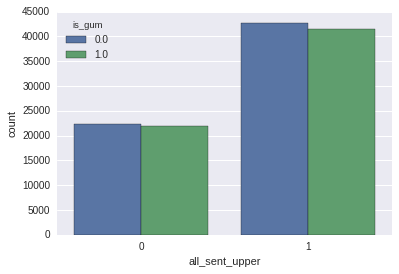

In [325]:
sns.countplot(x='all_sent_upper', hue='is_gum', data=comments)

### Punctuation count in comment

In [57]:
def punctuation_counts(comments, pattern='\(+', partion=True):
    if partion:
        return [len(re.findall(pattern, c)) / len(c) * 100 for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [58]:
comments_list[30:40]

['Вломил ему леща и дальше пошол работать, а он бы убежал и больше хер там появлялся! И все довольны все впорядке не синяков не побоев не свидетелей ни камер! Быстро, достойно, мощно!',
 'adddresssation из видео я понял что он заметил что Вы что то положили в сумку, если так то Вы зачиншик конфликта и тратить свое рабочее время на людей нарушающих внутренний порядок бессмысленно быстро решил проблему и отправил домой!',
 'adddresssation законов не кто не отменял но по распорядку магазин запрещено входить с сумками. Не опечатанными полиэтиленом! Дальше по закону просто вызывается наряд милиции и у вас будет привод! Это доставит не ему в вам проблем! И все по закону',
 'adddresssation распорядок по опечатки сумок есть! А о том делается он или нет в данном магазине это другой разговор! Всегда можно пожаловаться на отсутствие завленных услуг! Если нет жалобы то есть шкафчики! Все просто!',
 'adddresssation я выше уже написал. Ответ!',
 'Все вопросы к администратору магазина! Незнания поряд

In [161]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=False)

In [162]:
commas[:10]

[0, 0, 0, 1, 0, 1, 1, 1, 0, 0]

In [163]:
pd.Series(commas).value_counts()

0    107768
1     20742
dtype: int64

In [500]:
commas = np.reshape(commas, (-1, 1))

In [533]:
lr = lm.LogisticRegression()

In [503]:
lr = ensemble.RandomForestClassifier(10)

In [504]:
baseline_scores = cross_val_score(lr, commas, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


In [628]:
comments['commas'] = commas

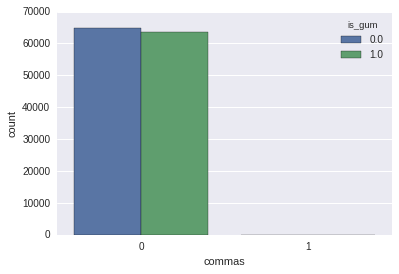

In [629]:
sns.countplot(x='commas', hue='is_gum', data=comments)

### Mean word length

In [130]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [526]:
comments_list[35:40]

['Все вопросы к администратору магазина! Незнания порядка не дает права вам нарушать его а жалобу можно отдать как администратору так и директору или есть такая КНИГА ЖАЛОБ',
 'Сука 100 р по везету и Вы в любом конце',
 'Папа новые даст не переживай😀',
 'Это чисто две банды долбоебов как от факела так и от динамо',
 'Сердце Егора ухнуло в пятки.']

In [530]:
mean_length = mean_word_length(comments_list)
mean_length[35:40]

[5.296296296296297, 3.0, 4.8, 4.0, 4.6]

In [531]:
mean_length = np.reshape(mean_length, (-1, 1))

In [534]:
baseline_scores = cross_val_score(lr, mean_length, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.520029569683 0.0124683358375


### Caps WORD

In [151]:
def caps_words(comments, partion=True):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [142]:
caps = caps_words(comments_list, False)

In [143]:
comments_list[:10]

['НАТЯНУЛИ МОСКВиЧЕЙ!!! ТЕПЕРЬ МОЖНО И ДОМОЙ ИХ ОТПРАВИТЬ 💪💪💪💪💪',
 'adddresssation не имеет значение где ЮР, ардрес то',
 'adddresssation где СК удобнее там и проводят а поближе подороже! Могу мск то сделать 650р',
 'Сегодня в 23:00 до 5:00 собираемся все НА АРЕНЕ и Валим там пока покрышки не сгорят... В ПРОТЕСТ СКУЧНЫМ И НУДНЫМ МУДАКАМ',
 'adddresssation пошлиб да проявили смелость там😉',
 'adddresssation любое ДТП есть страховой случай! И будет оплачиваться в законном порядке... А как в тебя въехали не ИМЕЕТ ЗНАЧЕНИЯ!',
 'adddresssation что если кого то что то неустраевает пойти и решить проблему, а не писать в типичный что под их окнами газуют...У ВСЕХ ГАЗУЮТ',
 'Норма у всех своя, а правила регулируют закон... А если так то действуй а не ори что у тебя проблема',
 'adddresssation да будет так',
 'Для особо одаренных есть ночные смены😀']

In [144]:
caps[:10]

[1, 0, 0, 1, 0, 1, 1, 0, 0, 0]

In [145]:
pd.Series(caps).value_counts()

0    124626
1      3884
dtype: int64

In [586]:
caps = np.reshape(caps, (-1, 1))

In [587]:
baseline_scores = cross_val_score(lr, caps, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.505563769356 0.0


### English words

In [152]:
def eng_words(comments, partion=True):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'adddresssation'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [128]:
engs = eng_words(comments_list, False)

In [129]:
pd.Series(engs).value_counts()

0    126611
1      1899
dtype: int64

In [617]:
engs = np.reshape(engs, (-1, 1))

In [619]:
lr = lm.LogisticRegression()

In [623]:
baseline_scores = cross_val_score(lr, engs, y, cv=10)
print(baseline_scores.mean(), baseline_scores.stdt())

0.505563769356 0.0


### All comments features together

In [153]:
def get_comments_features(comments):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(comments)
    big_letter, sents_count = sentence_stat(comments_list)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(comments, pattern='\)+')
    features['punct_('] = punctuation_counts(comments, pattern='\)+', partion=False)
    features['punct_...'] = punctuation_counts(comments, pattern='\.\.\.', partion=False)
    features['punct_?'] = punctuation_counts(comments, pattern='\?+')
    features['punct_!'] = punctuation_counts(comments, pattern='\!+')
    features['punct_..'] = punctuation_counts(comments, pattern='[\.]{2,}')
    features['eng_words'] = eng_words(comments, True)
    features['mean_word_len'] = mean_word_length(comments)
    features['caps'] = caps_words(comments, True)
    return features

In [154]:
features = get_comments_features(comments_list)

In [155]:
features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_...,punct_?,punct_!,punct_..,eng_words,mean_word_len,caps
count,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000,128510.000000
mean,0.087231,0.675706,1.758423,0.512834,0.250105,0.136915,0.408196,0.264073,0.279373,0.282136,4.734123,0.442253
std,0.282174,0.468112,1.256625,1.086672,0.433075,0.343759,1.017057,0.843832,0.784352,3.258406,1.058592,3.945057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.100000,0.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.666667,0.000000
75%,0.000000,1.000000,2.000000,0.184417,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.307692,0.000000
max,1.000000,1.000000,21.000000,15.384615,1.000000,1.000000,22.222222,16.666667,11.428571,159.090909,37.000000,120.000000


In [156]:
lr = lm.LogisticRegression()

In [165]:
lr = naive_bayes.MultinomialNB()

In [167]:
lr = ensemble.RandomForestClassifier(50, min_samples_leaf=3, max_features=0.8, n_jobs=-1)

In [266]:
lr = ensemble.GradientBoostingClassifier()

In [346]:
lr = lm.LogisticRegression()

In [347]:
np.random.seed(0)

In [ ]:
baseline_scores = cross_val_score(lr, features.values, comments.is_gum, cv=10)
print(baseline_scores.mean(), baseline_scores.std())